### 1)Extraction des données 

In [1]:
import os
from os import listdir, path
import tarfile
import random
import numpy as np
import keras
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#attention au path bien avoir une hierarchie : data -> Dossier suivant dans data : data_test.tar.gz ,data_train.tar.gz, data_train.csv 
if not path.exists('data/data_test/'):
    print('Extracting test image files...')
    tar = tarfile.open("./data/data_test.tar.gz", "r:gz")
    tar.extractall('data/')
if not path.exists('data/data_train/'):
    print('Extracting train image files...')
    tar = tarfile.open("./data/data_train.tar.gz", "r:gz")
    tar.extractall('data/')

### Display utility functions

In [3]:
def show(image):
    plt.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
    plt.title("image shape: "+ str(image.shape), fontsize=14)
    plt.axis('off');
    
def show_multiple(images, figsize):
    fig, ax = plt.subplots(ncols=len(images), figsize=figsize)
    for col, image in zip(ax, images):
        col.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
        col.set_title("image shape: "+ str(image.shape), fontsize=14)
    plt.tight_layout()
    plt.axis('off');

In [6]:
sample_image = imread("./data/data_train/10.jpg")
show(sample_image)

FileNotFoundError: [Errno 2] No such file or directory: './data/data_train/bee/10.jpg'

### Importer les Images (Train and Test) et les trier afin qu'elles soient en adéquation avec le fichier CSV

In [7]:
import pandas as pd

def load_data(data_path):
    csv_path = os.path.join(data_path, "labels_train.csv")
    return pd.read_csv(csv_path) # note the returned variable

In [9]:
GLOBAL_DATA_PATH = "./data"
data = load_data(GLOBAL_DATA_PATH) #Pemet de charger les données du CSV

In [10]:
import shutil, os

def split_img_in_subfolders(data) :
    for i in range(data.shape[0]) : 
        animal_folder_path = os.path.join('./','data', 'data_train', data['Category'][i])
        
        # Create folder if doesn't exist 
        if not path.exists(animal_folder_path):
            os.mkdir(animal_folder_path)
            
        # Copy the img in the associated folder    
        shutil.copy(os.path.join('./', 'data', 'data_train', str(data['Id'][i])) +'.jpg', os.path.join(animal_folder_path , str(data['Id'][i]) +'.jpg'))

In [11]:
split_img_in_subfolders(data)

In [12]:
def get_classes() :
    classes = []
    for animal in data['Category'] :
        if (animal not in classes) : 
            classes.append(animal)
        
    return classes

In [24]:
def get_splitted_data_with_size(image_size, sample_size, test_ratio, classes, seed):
    X, Y = [], []
    for label, animal in enumerate(classes):
        files = listdir(path.join('./data/data_train', animal))
        random.shuffle(files)
        files = files[:(sample_size // len(classes))]
        for file in files:
            img = load_img(path.join('./data/data_train', animal, file), 
                           target_size=image_size)
            X.append(img_to_array(img))
            Y.append(label)
    return train_test_split(np.asarray(X), np.asarray(Y), test_size=test_ratio, random_state=seed)

In [25]:
image_size = (32, 32, 3)
sample_size = 200
classes = get_classes()

X_tr, X_val, y_tr, y_val = get_splitted_data_with_size(
    image_size=image_size, sample_size=sample_size, test_ratio=0.25, classes=classes, seed=42
)

In [26]:
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((146, 32, 32, 3), (49, 32, 32, 3), (146,), (49,))

In [6]:
def conv(v):
    v2 = [s.strip('.jpg') for s in v] # remove the .jpg from the string borders 
    v2 = list(map(int, v2))
    return v2

In [7]:
def int_to_imagepath (v):
    v1 = list(map(str, v))
    #print (v1)
    v1 = [s.replace(s,s+".jpg") for s in v1] 
    return v1

    Id    Category
0    0      rabbit
1    1  chimpanzee
2    2    kangaroo
3    3        bear
4    4      rabbit
5    5    kangaroo
6    6     dolphin
7    7         fox
8    8        wolf
9    9         bee
10  10         bee
y lenght :  7200
X lenght :  7200


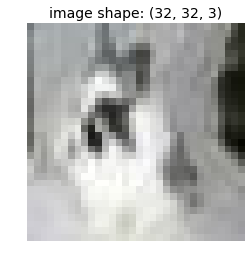

In [68]:
GLOBAL_DATA_PATH = "./data"

X_train = []
files = []
files = listdir(path.join(GLOBAL_DATA_PATH, "data_train"))
#files.remove('.ipynb_checkpoints') #Permet de vérifier qu'il n'ai pas d'élément avec ".ipynb_checkpoints"
files2 = conv(files) # convertion string to int
files3 = sorted(files2) # classement ordre croissant
files4 = int_to_imagepath (files3) #converte the sort list to a sort list with ".jpg"

for file in files4:
    img = load_img(path.join(GLOBAL_DATA_PATH, "data_train", file))
    X_train.append(img_to_array(img))

data = load_data(GLOBAL_DATA_PATH) #Pemet de charger les données du CSV

show(X_train[0])

print(data.head(11))
print("y lenght : ",len(y_train))
print("X lenght : ",len(X_train))

In [10]:
X_test = []
files = []
files = listdir(path.join(GLOBAL_DATA_PATH, "data_test"))

for file in files:
    img = load_img(path.join(GLOBAL_DATA_PATH, "data_train", file))
    X_test.append(img_to_array(img))

print("X_test lenght : ",len(X_test))

X_test lenght :  1800


### MODEL : VIA RESNET 50 

In [11]:
import numpy as np
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
from skimage.transform import resize
from skimage.io import imread

In [36]:
 #Basic Implementation of resnet model
model_ResNet50 = ResNet50(include_top=True, weights='imagenet')
#model_ResNet50.summary()

/home/jerem/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


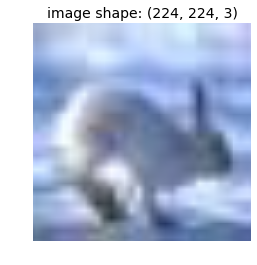

In [13]:
#We will resized the unique image to resnet image 
resnet_input_size = (224,224)
img = X_train[4]
img_resized = resize(img, resnet_input_size, mode='reflect', preserve_range=True)
show(img_resized)

In [ ]:
preds = model_ResNet50.predict(img_resized)
decode_predictions(preds, top=5)

In [38]:
#Print prediction of the unique image 
x = image.img_to_array(img_resized)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model_ResNet50.predict(x)
        
decoded_predictions = decode_predictions(preds)

if decoded_predictions:
    for _, name, score in decoded_predictions[0]:
        print(name, score)

dugong 0.44612902
fox_squirrel 0.16203322
grey_whale 0.14001317
Arctic_fox 0.08744889
ice_bear 0.038717896


In [19]:
model_ResNet50.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [67]:
model_ResNet50.fit(
        x=X_train, 
        y=y_train['Category'], 
        batch_size=20, 
        epochs=20)

AssertionError: 

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

batch_size = 128
num_epochs = 20

model = Sequential()

model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
    
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
if model:
    model_history = model.fit(
        x=X_train, 
        y=y_train['Category'], 
        batch_size=20, 
        epochs=20)
        #verbose=1
        #validation_data=(X_extracted_val, Y_val)
    
    print('Training complete')
else:
    model_history = None

AssertionError: 